<a href="https://colab.research.google.com/github/iu5git/Deep-learning/blob/main/notebooks/Forest_sat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Лабораторная работа №7

# Задание

В первой части работы обучите модель U-net. Во второй части создайте и сравните три вида ансамблей (Average, WeightedAverageLayer, Stacking Ensemble) на основе моделей бинарной сегментации поврежденных областей леса.



# Задания для самостоятельной работы

1. В первой части работы обучите U-net с подбором гиперпараметров
2. Попробуйте разные комбинации моделей в ансамбле, поменяйте их количество
3. Подберите лучшие веса для WeightedAverageLayer
4. Поменяйте выходную часть в Stacking Ensemble (количество слоёв, их параметры)

# Контрольные вопросы для защиты

1. Что такое ансамбль моделей? Meta-learner?
2. Способы объединения моделей в ансамбль
3. Архитектура U-Net
4. Выходные слои нейронной сети для сегментации
5. Оценка качества сегментации. Dice коэффициент.

# Импортирование библиотек

In [ ]:
!pip install numpy==1.23.5 tensorflow==2.12.0 imgaug==0.4.0

In [ ]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
from skimage import io
import random

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping,
                                        ModelCheckpoint,
                                        ReduceLROnPlateau,
                                        CSVLogger,
                                        TensorBoard,
                                        LearningRateScheduler
                                       )
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

from imgaug import augmenters as iaa

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib as mpl
from PIL import ImageEnhance

In [ ]:
tf.config.list_physical_devices('GPU')

[]

# Загрузка данных

In [48]:
!gdown --folder https://drive.google.com/drive/folders/1XRemc1-sotxGNaivNNbmMLOK_Q8Q2K4D

In [ ]:
%%capture
!tar -xzf NN_Satellite/tiles_256_256_27_test.tar.gz
!tar -xzf NN_Satellite/tiles_256_256_27_train.tar.gz
!tar -xzf NN_Satellite/files.tar.gz

!mv tiles_256_256_27_after_check_test tiles_256_256_27_train

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# local_download_path = "/content/drive/My Drive/Colab Notebooks"
local_download_path = ''

# Часть 1. U-Net для семантической сегментации лесных повреждений

Теоретическая часть, которую можно не изменять. Здесь определяется несколько функций, которые будут использоваться в дальнейшем.

## Исследование данных

__Данные.__ Многоспектральные спутниковые снимки, разрезанные на части 256х256 пикселей и объединённые в пары старый-новый.

Для обнаружения лесных повреждений мы должны сравнить пары старых и новых снимков. В простейшем случае для этого достаточно вычесть одно изображение из другого (это же матрицы), а затем рассмотреть, для каких пикселей разность сильно отличается от нуля. Понятное дело в реальности дело осложняется разными условиями съёмки, дефектами и т.д.

Для обучения используются изображения со спутника Sentinel-2 в формате geoTiff. GeoTiff - это подмножество формата хранения растровых графических изображений tiff, в котором содержится дополнительная геоинформация. Для получения этой геоинформации (например, координат снимков) можно использовать множество библиотек, в том числе GDAL, но для текущих задач это не нужно.

В директории содержатся как снимки с объектами (with_object), так и без них (no_object).

In [ ]:
os.listdir(local_download_path + 'tiles_256_256_27_train/T39VXJ_pair_0.tif')

['T39VXJ_pair_0.tif_4606_5137_with_object.tif',
 'T39VXJ_pair_0.tif_9332_4314_with_object.tif',
 'T39VXJ_pair_0.tif_5876_9112_no_object.tif',
 'T39VXJ_pair_0.tif_5741_2842_with_object.tif',
 'T39VXJ_pair_0.tif_3840_6861_with_object.tif',
 'T39VXJ_pair_0.tif_1314_5184_no_object.tif',
 'T39VXJ_pair_0.tif_7486_1060_no_object.tif',
 'T39VXJ_pair_0.tif_6864_4150_no_object.tif',
 'T39VXJ_pair_0.tif_9461_4469_with_object.tif',
 'T39VXJ_pair_0.tif_7316_6577_no_object.tif',
 'T39VXJ_pair_0.tif_3862_8739_no_object.tif',
 'T39VXJ_pair_0.tif_5472_9750_no_object.tif',
 'T39VXJ_pair_0.tif_10266_2688_no_object.tif',
 'T39VXJ_pair_0.tif_6059_2678_with_object.tif',
 'T39VXJ_pair_0.tif_5986_2668_with_object.tif',
 'T39VXJ_pair_0.tif_10545_3215_no_object.tif',
 'T39VXJ_pair_0.tif_4640_5155_with_object.tif',
 'T39VXJ_pair_0.tif_5646_3105_with_object.tif',
 'T39VXJ_pair_0.tif_3679_6602_with_object.tif',
 'T39VXJ_pair_0.tif_9447_4261_with_object.tif',
 'T39VXJ_pair_0.tif_965_2383_no_object.tif',
 'T39VXJ_pa

Объединим пути ко всем изображениям в один список для удобства при дальнейшей работе.

In [ ]:
allTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_train/*/*with_object.tif'))

Посмотрим на размерность одного из изображений.

In [ ]:
img = io.imread(allTiles[0])/65536

img.shape

(256, 256, 27)

Видим, что изображение - это трёхмерный массив. 256 пикселей по вертикали и по горизонтали, а также 27 каналов "в глубину". Sentinel-2 ведет съёмку не только в 3 привычных каналах видимого спектра (синий, зеленый и красный), но также и в невидимых глазу диапазонах: коротковолновом инфракрасном (SWIR), видимом ближнем инфракрасном (VNIR) и т.д., - всего 13 каналов.

Канал |	Разрешение	| Центральная длина волны |	Описание
--------|--------|--------|--------
B1	| 60 m	| 443 nm	| Ultra Blue (Coastal and Aerosol)
B2	| 10 m	| 490 nm	| Blue
B3	| 10 m	| 560 nm	| Green
B4	| 10 m	| 665 nm	| Red
B5	| 20 m	| 705 nm	| Visible and Near Infrared (VNIR)
B6	| 20 m	| 740 nm	| Visible and Near Infrared (VNIR)
B7	| 20 m	| 783 nm	| Visible and Near Infrared (VNIR)
B8	| 10 m	| 842 nm	| Visible and Near Infrared (VNIR)
B8a	| 20 m	| 865 nm	| Visible and Near Infrared (VNIR)
B9	| 60 m	| 940 nm	| Short Wave Infrared (SWIR)
B10	| 60 m	| 1375 nm   | Short Wave Infrared (SWIR)
B11	| 20 m	| 1610 nm   | Short Wave Infrared (SWIR)
B12	| 20 m	| 2190 nm   | Short Wave Infrared (SWIR)


В наших данных заранее совмещены пары старых снимков (со все ещё с нетронутым лесом) и новых (с повреждением), а также маска (с отмеченным повреждением). Так что всего получается 13+13+1=27 каналов. Порядок их следования в нашем трехмерном массиве следующий:

    Маска - 0
    Новый снимок
    ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
    [ 1,     2,    3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13  ]
    Старый снимок
    ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"]
    [ 14,    15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26  ];

В маске разными цифрами указаны следующие классы:
*   1 - Сплошная рубка
*   2 - Проходная рубка
*   3 - Лесная дорога
*   4 - Ветровал
*   5 - Пожар
*   6 - Усыхание (повреждение)
*   7 - Выборочная рубка

Мы собираемся обучать модели всего лишь для бинарной сегментации, так что достаточно будет проверить, больше ли нуля значение маски.

Попробуем посмотреть на один из каналов изображения простейшим способом (2 канал соответствует синему спектру нового снимка)

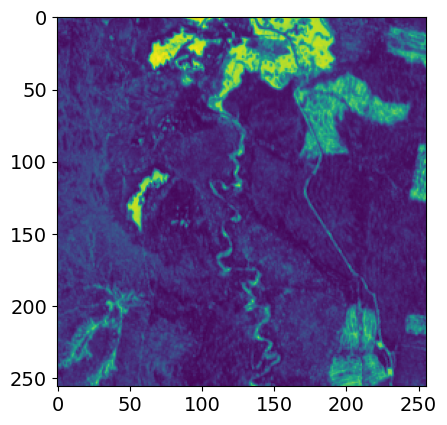

In [ ]:
plt.imshow(img[:,:,2])

Привычнее было бы смотреть на RGB-изображение, так что создадим функции для выделения старого и нового набора rgb-каналов.

In [ ]:
def get_rgb_new(img):
    c1 = 4
    c2 = 3
    c3 = 2
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img

def get_rgb_old(img):
    c1 = 17
    c2 = 16
    c3 = 15
    img = np.stack([img[::, ::, c1] / img[::, ::, c1].max() ,
                img[::, ::, c2] / img[::, ::, c2].max(),
                img[::, ::, c3] / img[::, ::, c3].max()], axis=2)
    return img

Введём также функцию для симпатичного отображения маски (show_mask) и нормализации яркости и контрастности изображения (show_img_norm). Можете в них слишком не вдумываться.

In [ ]:
def show_mask(data, k):
    labels = ['-', 'Сплошная рубка', 'Проходная рубка', 'Лесная дорога', 'Ветровал', 'Пожар', 'Усыхание', 'Выборочная рубка']
    my_colors = ['g', 'b', 'r', 'black', 'c', 'm', 'y', 'black']
    cmap = colors.ListedColormap(my_colors)
    bounds=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    values = np.unique(data.ravel()).astype(int)
    im = plt.imshow(X=data, cmap=cmap, norm=norm)

    patches = [ mpatches.Patch(color=my_colors[values[i]],
                               label=f"{values[i]} : {labels[values[i]]}" ) for i in range(len(values)) ]

    axes[k].legend(loc="lower right", handles=patches, bbox_to_anchor=(1, 1))
    axes[k].set_title('Маска')
    axes[k].axis('off')

def show_img_norm(img, k):
    img = (img*255).astype(np.uint8)
    img = Image.fromarray(img, 'RGB')

    enhancer = ImageEnhance.Brightness(img)
    factor = 0.8
    im_output = enhancer.enhance(factor)

    enhancer = ImageEnhance.Contrast(im_output)
    factor = 1.3
    im_output = enhancer.enhance(factor)

    axes[k].imshow(im_output)
    axes[k].axis('off')

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
for tileS in random.sample(allTiles, 5):
    img = io.imread(tileS)

    fig,axes = plt.subplots(ncols=3,figsize=(50,50))
    plt.title(os.path.basename(tileS))

    show_img_norm(get_rgb_old(img), 0)
    axes[0].set_title('Старый снимок')

    show_img_norm(get_rgb_new(img), 1)
    axes[1].set_title('Новый снимок')

    show_mask( img[:,:,0], 2)

Output hidden; open in https://colab.research.google.com to view.

Итак, мы разобрались, как выделить обычную rgb-картинку из спутникового снимка. Данные в невидимых спектрах при этом тоже очень полезны. Например, в инфракрасном диапазоне легче увидеть пожары (данные о теплоте). Кроме этого, можно использовать разные *комбинации* каналов для выявления определенных особенностей изображения.

## Архитектуры

### U-Net

U-Net считается одной из стандартных архитектур CNN для задач сегментации изображений, когда нужно не только определить класс изображения целиком, но и сегментировать его области по классу, т. е. создать маску, которая будет разделять изображение на несколько классов. Архитектура состоит из стягивающего пути для захвата контекста и симметричного расширяющегося пути, который позволяет осуществить точную локализацию.
![title](https://lh6.googleusercontent.com/Rx30jfXZqXnWX8CjmBaztePGMtCydUyeR_D6o1o-2kVnyg2cX-yyEmwYheeWJR2vxEAepYromNrriGyLeGuZatztKdCYCmiIrsSspW75EX9WxvOivLPKxfwkIvQji9MzJIHK0y5V)
Архитектура состоит из сужающегося пути (слева) и расширяющегося пути (справа). Сужающийся путь — типичная архитектуре сверточной нейронной сети. Он состоит из повторного применения двух сверток 3×3, за которыми следуют инит ReLU и операция максимального объединения (2×2 степени 2) для понижения разрешения. Размер слоев становится все меньше и меньше для изучения более тонких функций эффективным с вычислительной точки зрения способом — процесс, известный как «понижающая выборка».

Сеть включает 4 соединения с пропуском — после каждой транспонированной свертки (или «up-conv») на пути повышающей дискретизации результирующая карта объектов объединяется с одной из пути понижающей дискретизации.

На каждом этапе понижающей дискретизации каналы свойств удваиваются. Каждый шаг в расширяющемся пути состоит из операции повышающей дискретизации карты свойств, за которой следуют:

- свертка 2×2, которая уменьшает количество каналов свойств;
- объединение с соответствующим образом обрезанной картой свойств из стягивающегося пути;
- две 3×3 свертки, за которыми следует ReLU.

На последнем слое используется свертка 1×1 для сопоставления каждого 64-компонентного вектора свойств с желаемым количеством классов.

Кроме того добавим слои Dropout() для увеличения обобщающей способности сети. Параметр 0,5 означает, что в среднем, при обучении будет использоваться половина нейронов из 256 предыдущего полносвязного слоя. Это позволит снизить (а в идеале исключить) эффект переобучения.

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    #x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
   # x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model(size = 256,channels=6):

    num_filters = [16, 32, 48, 64] # original
    inputs = Input((size, size, channels))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.5)(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = Dropout(0.5)(x)
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
model = build_model(256,16)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                6)]                                                               
                                                                                                  
 conv2d_256 (Conv2D)            (None, 256, 256, 16  2320        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_297 (Batch  (None, 256, 256, 16  64         ['conv2d_256[0][0]']             
 Normalization)                 )                                                           

Обратите внимание, что на выходе U-Net нет полносвязных слоёв, как в сетях для классификации. Сейчас мы используем её для сегментации и в результате хотим получить картинку-маску, размер которой зависит от размера входного изображения.
В качестве функции активации используется sigmoid, потому что это бинарная сегментация (для мультиклассовой применялась бы softmax)

## Подготовка данных

Для подготовки данных в keras есть стандартный ImageGenerator, с помощью которого можно нормализовать изображения, добавить аугументации к данным, отделить данные для валидации и т. д.

Вместо этого мы реализуем собственный DataGenerator для обработки мультиспектральных данных.
На вход модели будем подавать набор из части исходных каналов, некоторых разностей, а также NDVI индекс, о котором мы говорили в предыдущем разделе. Наиболее удачный набор каналов был определен экспериментально. В дальнейшем при использовании обученной модели необходимо будет выделять из тестовых изображений тот же самый набор каналов

Также к формируемому батчу в getitem можно применить аугументации с помощью imgaug. Аугментация данных — это методика создания дополнительных данных из имеющихся данных.
Полный список возможных аугументаций: https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html

In [ ]:
# тут рассчитываем входные признаки (производные или исходные и т.д.)
def prepare_snaps(img):
    return np.array(
            np.dstack([
                    img[:,:,4],
                    img[:,:,8],
                    img[:,:,17],
                    img[:,:,21],
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12],
                ])).astype('float32')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, inputTiffs, batch_size=32, num_classes=2, num_models=1, shuffle=True):
        self.inputTiffs = inputTiffs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_models = num_models
        self.shuffle = shuffle
        self.on_epoch_end()
        #custom augmentation with imgaug lib
        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0,2),
                [
                    #iaa.Add((-30, -10)), # change brightness of images (by -10 to 10 of original value)
                    #iaa.Multiply((0.8, 1.2)),

                    # Geometric transfroms
                    iaa.Rotate((-45,45)),
                    iaa.TranslateX(px=(-20, 20)),
                    iaa.TranslateY(px=(-20, 20)),
                ]
                ),
            ],
            random_order=True
        )

    def __len__(self):
        return len(self.inputTiffs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batchTifs = [self.inputTiffs[k] for k in indexes]
        # self.aug_pipe(images=batchTifs)

        X, y = self._get_data(batchTifs)

        if self.num_models > 1:
          X = [X for _ in range(self.num_models)]

        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.inputTiffs))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def _get_data(self, batch):
        X = []
        y = []

        for idx,imagePath in enumerate(batch):
            img = (io.imread(imagePath)/65536).astype('float32')

            # здесь важно учесть, сколько классов мы хотим
            # сейчас все лесные повреждения сводятся к одному
            y.append(np.where(img[:,:,0]>0,1,0).astype('int'))
            # y.append(np.where(img[:,:,0]==1/65536,1,0).astype('int'))

            X.append(prepare_snaps(img))

        return np.array(X), np.array(y)

    def flip(self,image):
        flipDirection = np.random.randint(-1,1,1)[0]
        return cv2.flip(image,flipDirection)

## Метрики

In [ ]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

def DiceBCELoss(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    BCE =  binary_crossentropy(targets, inputs)
    dice_loss = dice_loss(y_true, y_pred)
    Dice_BCE = BCE + dice_loss

    return Dice_BCE

def tversky(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Обучение

### Tensorflow

Для обучения полноценной модели с нуля нужно много времени и данных. Вы можете попробовать обучить не слишком хорошую модель за 10-20 эпох или же загрузить и дообучить уже существующую (во втором случае нужно уменьшить learning rate, чтобы старые веса затирались не слишком быстро)

Предварительно было обучено несколько моделей с разными функциями потерь, перечисленными ниже.

In [ ]:
input_shape = (256, 256, 16)

model = build_model(size=256,channels=16) # unet
# model = attention_unet(input_shape)
# model = build_multiresunet(input_shape)
# model = build_colonsegnet(input_shape)

lr = 1e-3

opt = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = [dice_coefficient]

model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
          ModelCheckpoint("model.h5"),
          ReduceLROnPlateau(monitor='loss',factor=0.1, patience=15,min_lr=1e-8, mode='min'),
          CSVLogger("data.csv"),
          # EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
          # TensorBoard("log", histogram_freq=10, embeddings_freq=10, update_freq=3000),
]

In [ ]:
batch = 8
epochs = 20

trainTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_train/*/*.tif'))
# trainTiles = list(glob.glob(local_download_path + '/tiles_256_256_27_after_check/*/*.tif'))
print(len(trainTiles))
validSize = int(len(trainTiles)*0.15)
print(validSize)

train_generator = DataGenerator(trainTiles[:-validSize],batch_size=batch,num_models=1)
valid_generator = DataGenerator(trainTiles[-validSize:],batch_size=batch,num_models=1)

hist = model.fit(train_generator,
                    steps_per_epoch=len(trainTiles[:-validSize])//batch,
                    validation_data=valid_generator,
                    epochs=epochs,
                    validation_steps=len(trainTiles[-validSize:])//batch,
                    callbacks=callbacks
                )

Посмотрим процесс обучения одной из моделей

In [ ]:
model = tf.keras.models.load_model(local_download_path + 'files/model186_dice.h5', compile=False)

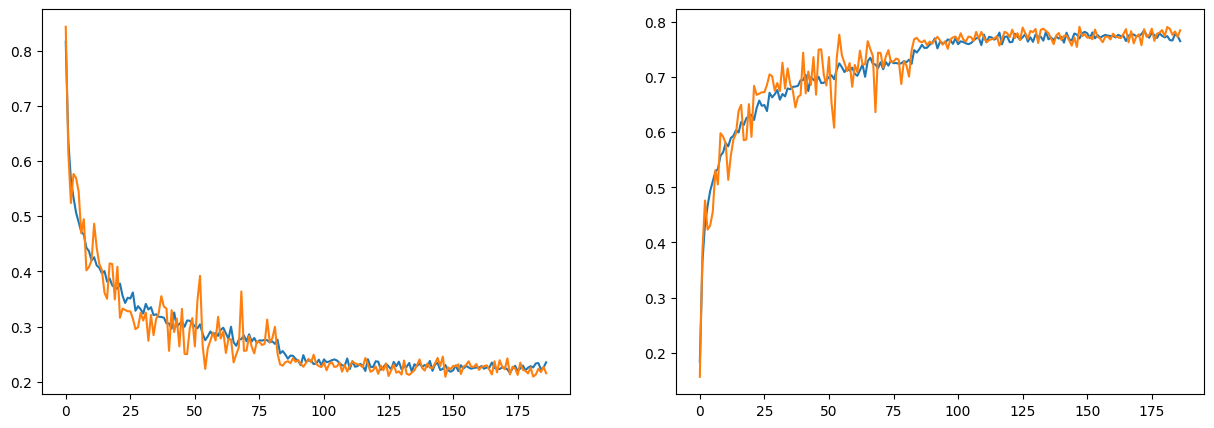

In [ ]:
df = pd.read_csv(local_download_path + 'files/data186_dice.csv')
df.head()

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(df.epoch, df["loss"], label="Train loss")
ax_loss.plot(df.epoch, df["val_loss"], label="Validation loss")
ax_acc.plot(df.epoch, df["dice_coefficient"], label="Train accuracy")
ax_acc.plot(df.epoch, df["val_dice_coefficient"], label="Validation accuracy")

## Оценка обученной модели

Для оценки эффективности модели рассчитаем Dice коэффициент, который показывает попиксельное соотношение между прогнозируемой маской и соответствующей ей истиной. Коэффициент Dice — это двойная площадь их пересечения, деленная на общее количество пикселей в обоих изображениях.

$$
    DC = \frac{2TP}{2TP+FP+FN} = \frac{2|X*Y|}{|X|+|Y|}
$$

Dice принимает значения от 0 до 1 (полное совпадение)

Существуют также другие метрики для оценки качества сегментации, например IoU.

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
testTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_test/*/*.tif'))

Используем round_original, чтобы заменить маску тестового изображения на бинарную, а prepare_snaps, чтобы выделить ту же самую комбинацию каналов, что и при обучении модели (в DataGenerator).

In [ ]:
def round_original(a):
    new = [1 if i > 0 else 0 for i in a]
    return np.array (new)

In [ ]:
def predict(model, testTiles, num_models=1):
  print(num_models)
  original_list = []

  original_img_list = []

  predict_mask_list = []

  for testImg in testTiles:
      img = io.imread(testImg)
      original_img_list.append( img )
      img = img /65536
      original_list.append( np.apply_along_axis( round_original, 1, img[:,:,0] ).astype('float32') )

      toPredict = prepare_snaps(img)

      if num_models==1:
        testPrediction = model.predict(np.array([toPredict]));
      else:
        print('here')
        testPrediction = model.predict([np.array([toPredict]) for _ in range(num_models) ]);

      predict_mask_list.append(testPrediction[0,:,:,0].astype('float32'))

  dice = dice_coefficient(original_list, predict_mask_list)

  return dice, original_img_list, predict_mask_list

In [ ]:
%%capture
dice, original_img_list, predict_mask_list = predict(model, testTiles);

In [ ]:
dice.numpy()

0.7865361

In [ ]:
offset = 58
for i in range(5):

    fig,axes = plt.subplots(ncols=4,figsize=(50,50))

    show_img_norm(get_rgb_old(original_img_list[i+offset]), 0)
    axes[0].set_title('Старый снимок')

    show_img_norm(get_rgb_new(original_img_list[i+offset]), 1)
    axes[1].set_title('Новый снимок')

    axes[2].imshow(original_img_list[i+offset][:,:,0].astype('float32'))
    axes[2].set_title('Оригинальная маска')
    axes[2].axis('off')

    axes[3].imshow(predict_mask_list[i+offset].astype('float32'))
    axes[3].set_title('Предсказанная маска')
    axes[3].axis('off')

Output hidden; open in https://colab.research.google.com to view.

# Часть 2. Ансамблирование моделей нейронных сетей

Нейронные сети учатся с помощью стохастических алгоритмов, так что они могут находить каждый раз разные наборы весов и в свою очередь делать разные прогнозы. Для уменьшения разброса предсказаний можно обучить нескольких моделей вместо одной и объединенить результаты этих моделей. Ансамбль моделей может оказаться более стабильным, а иногда и более эффективным решением.

Важно, чтобы модели в ансамбле были хороши по-разному и делали разные ошибки, которые могут затем взаимно компенсировать. Можно варьировать данные для обучения, гиперпараметры, архитектуры подмоделей.

В примере используются несколько unet-моделей с разными функциями потерь.

In [ ]:
local_download_path = ''

In [ ]:
testTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_test/*/*.tif'))
len(testTiles)

117

In [ ]:
trainTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_train/*/*.tif'))
len(trainTiles)

572

In [ ]:
model1 = tf.keras.models.load_model(local_download_path + 'files/model186_dice.h5', compile=False)
model2 = tf.keras.models.load_model(local_download_path + 'files/model230_bc.h5', compile=False)
model3 = tf.keras.models.load_model(local_download_path + 'files/model230_tversky.h5', compile=False)
model4 = tf.keras.models.load_model(local_download_path + 'files/model230_dice_bc.h5', compile=False)
model5 = tf.keras.models.load_model(local_download_path + 'files/model_dice_wind.h5', compile=False)

In [ ]:
model1._name = 'model_1'
model2._name = 'model_2'
model3._name = 'model_3'
model4._name = 'model_4'
model5._name = 'model_5'

In [ ]:
members = [model1, model2, model3, model4, model5]

Мы не собираемся менять подмодели, так что сделаем их слои необучаемыми. Также переименуем их, чтобы избежать 'unique layer name' ошибки

In [ ]:
for i in range(len(members)):
  model = members[i]
  for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [ ]:
print("Количество слоёв в базовой модели: ", len(model2.layers))

print("weights:", len(model2.weights))
print("trainable_weights:", len(model2.trainable_weights))
print("non_trainable_weights:", len(model2.non_trainable_weights))

Количество слоёв в базовой модели:  77
weights: 110
trainable_weights: 74
non_trainable_weights: 36


## Усреднение прогнозов моделей

Самый простой способ объединения предсказания подмоделей - это рассчитать их среднее значение. Также можно добавить веса, чтобы сделать более ощутимым вклад удачных моделей.

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, w4, w5, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] + self.w4 * inputs[3] + self.w5 * inputs[4]

In [ ]:
model_input = tf.keras.Input(shape=(256, 256, 16))
model_outputs = [model(model_input) for model in members]
# ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_output = WeightedAverageLayer(0.6, 0, 0.3, 0.1, 0)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
%%capture
dice1 = predict(model1, testTiles)[0];
dice2 = predict(model2, testTiles)[0];
dice3 = predict(model3, testTiles)[0];
dice4 = predict(model4, testTiles)[0];
dice5 = predict(model5, testTiles)[0];
dice_ensemble = predict(ensemble_model, testTiles)[0];

In [ ]:
print('Dice Score for model1 = ', dice1.numpy())
print('Dice Score for model2 = ', dice2.numpy())
print('Dice Score for model3 = ', dice3.numpy())
print('Dice Score for model4 = ', dice4.numpy())
print('Dice Score for model5 = ', dice5.numpy())
print('Dice Score for ensemble = ', dice_ensemble.numpy())

## Stacking Ensemble

Мы можем обучить мета-ученика, который будет сочетать прогнозы из подмоделей и в идеале делать предсказания точнее, чем любая отдельная подмодель. В качестве мета-ученика можно использовать МЛ-модель (линейную регрессию и т.д.) или нейронную сеть. Во втором случае можно рассматривать стековый ансамбль как единую большую модель (multi-headed model). Подмодели могут быть встроены в более крупную многоголовую нейронную сеть, которая затем учится, как лучше всего комбинировать прогнозы из каждой входной подмодели.



In [ ]:
members = [model1, model3]
# members = [model1, model2, model3, model4, model5]

Входному слою каждой подмодели нужно предоставить свои входные данные (в данном случае одинаковые). Так что всей multi-headed модели нужно будет предоставить k копий входных данных, на основе которых уже будут сделаны предсказания.

Потом результаты каждой из моделей можно объединить с помощью простой конкатенации.

Затем скрытый слой будет подбирать веса для интерпретации этого «ввода», а выходной слой (сверточный+активация sigmoid) делать свой собственный вероятностный прогноз.

In [ ]:
for i in range(len(members)):
  model = members[i]
  for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [ ]:
from keras.layers import concatenate

ensemble_visible = [model.input for model in members]
ensemble_outputs = [model.output for model in members]
x = concatenate(ensemble_outputs)

x = Conv2D(16, (3, 3), padding="same")(x)
#x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(1, (1, 1), padding="same")(x)
x = Activation("sigmoid")(x)
ensemble_model = Model(inputs=ensemble_visible, outputs=x, name='ensemble_model')

Веса подмоделей не будут обновляться во время обучения. Тренируются только добавленные после конкатенации слои.

In [ ]:
print("Количество слоёв в базовой модели: ", len(ensemble_model.layers))

print("weights:", len(ensemble_model.weights))
print("trainable_weights:", len(ensemble_model.trainable_weights))
print("non_trainable_weights:", len(ensemble_model.non_trainable_weights))

Количество слоёв в базовой модели:  160
weights: 228
trainable_weights: 6
non_trainable_weights: 222


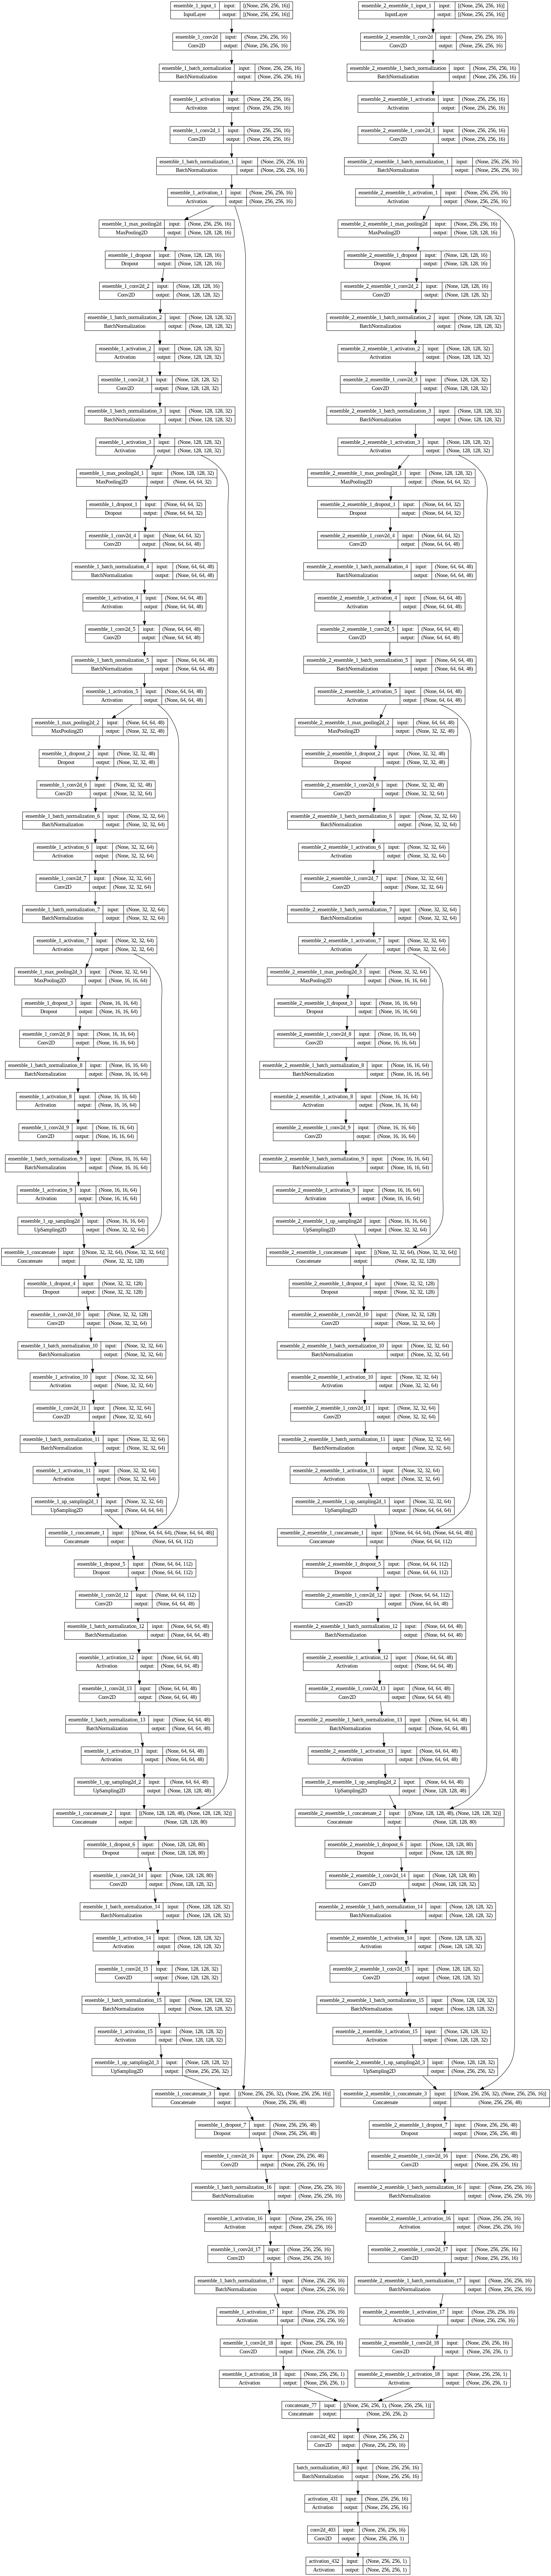

In [ ]:
from keras.utils import plot_model
plot_model(ensemble_model, show_shapes=True, to_file='model_graph.png')

Обратите внимание, что здесь требуются два входа для обеих моделей. Поэтому нам нужно будет продублировать X, это уже предусмотрено в DataGenerator параметром num_models.

```python
  if self.num_models > 1:
          X = [X for _ in range(self.num_models)]
          y = [y for _ in range(self.num_models)]
```

In [ ]:
lr = 4e-3

opt = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = [dice_coefficient]

ensemble_model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
          ModelCheckpoint("model.h5"),
          ReduceLROnPlateau(monitor='loss',factor=0.1, patience=2,min_lr=1e-8, mode='min'),
          CSVLogger("data.csv"),
          # EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
          # TensorBoard("log", histogram_freq=10, embeddings_freq=10, update_freq=3000),
]

In [ ]:
batch = 8
epochs = 5

validSize = int(len(trainTiles)*0.15)

train_generator = DataGenerator(trainTiles[:-validSize],batch_size=batch,num_models=len(members))
valid_generator = DataGenerator(trainTiles[-validSize:],batch_size=batch,num_models=len(members))

hist = ensemble_model.fit(train_generator,
                    steps_per_epoch=len(trainTiles[:-validSize])//batch,
                    validation_data=valid_generator,
                    epochs=epochs,
                    validation_steps=len(trainTiles[-validSize:])//batch,
                    # callbacks=callbacks
                )

Epoch 1/5
60/60 [==============================] - 164s 3s/step - loss: 0.9444 - dice_coefficient: 0.0556 - val_loss: 0.9503 - val_dice_coefficient: 0.0497
Epoch 2/5
60/60 [==============================] - 176s 3s/step - loss: 0.7350 - dice_coefficient: 0.2650 - val_loss: 0.5252 - val_dice_coefficient: 0.4749
Epoch 3/5
60/60 [==============================] - 163s 3s/step - loss: 0.2934 - dice_coefficient: 0.7067 - val_loss: 0.2832 - val_dice_coefficient: 0.7168
Epoch 4/5
60/60 [==============================] - 156s 3s/step - loss: 0.2283 - dice_coefficient: 0.7717 - val_loss: 0.2405 - val_dice_coefficient: 0.7596
Epoch 5/5
60/60 [==============================] - 165s 3s/step - loss: 0.2115 - dice_coefficient: 0.7886 - val_loss: 0.2138 - val_dice_coefficient: 0.7863


In [ ]:
tf.config.run_functions_eagerly(True)

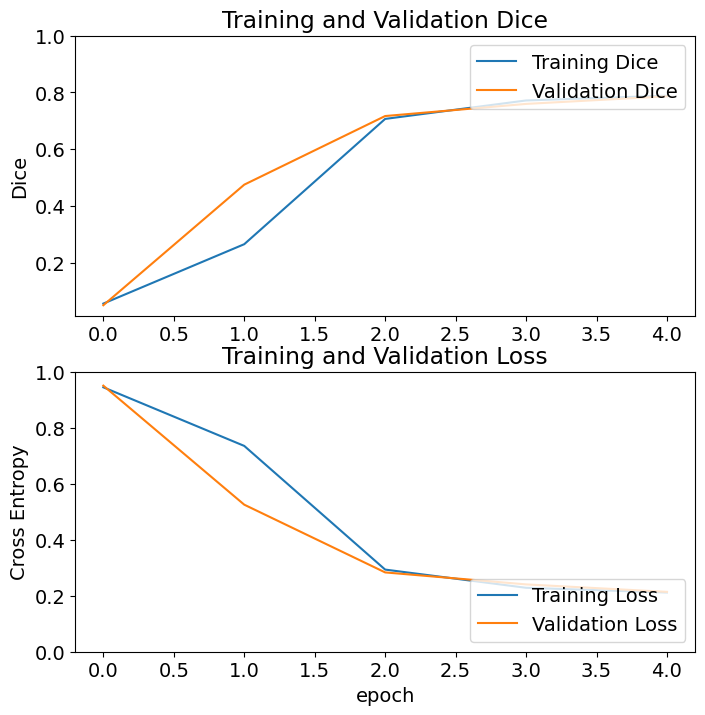

In [ ]:
acc = hist.history['dice_coefficient']
val_acc = hist.history['val_dice_coefficient']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Dice')
plt.plot(val_acc, label='Validation Dice')
plt.legend(loc='upper right')
plt.ylabel('Dice')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Dice')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
%%capture
dice1 = predict(model1, testTiles)[0];
dice2 = predict(model2, testTiles)[0];
dice3 = predict(model3, testTiles)[0];
dice4 = predict(model4, testTiles)[0];
dice5 = predict(model5, testTiles)[0];
dice_ensemble = predict(ensemble_model, testTiles, num_models=2)[0];

In [ ]:
print('Dice Score for model1 = ', dice1.numpy())
print('Dice Score for model2 = ', dice2.numpy())
print('Dice Score for model3 = ', dice3.numpy())
print('Dice Score for model4 = ', dice4.numpy())
print('Dice Score for model5 = ', dice5.numpy())
print('Dice Score for ensemble = ', dice_ensemble.numpy())

Dice Score for model1 =  0.78653604
Dice Score for model2 =  0.7272333
Dice Score for model3 =  0.77293926
Dice Score for model4 =  0.7673298
Dice Score for model5 =  0.6782828
Dice Score for ensemble =  0.7855987
